In [76]:
# Problem Set 3

In [3]:
# Installing Lightkurve
! python -m pip install lightkurve --upgrade

  Using cached lightkurve-2.4.1-py3-none-any.whl (265 kB)
  Using cached uncertainties-3.1.7-py2.py3-none-any.whl (98 kB)
  Using cached memoization-0.4.0.tar.gz (41 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached oktopus-0.1.2.tar.gz (10 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached astroquery-0.4.6-py3-none-any.whl (4.5 MB)
  Using cached fbpca-1.0.tar.gz (11 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached html5lib-1.1-py2.py3-none-any.whl (112 kB)
  Using cached pyvo-1.4.2-py3-none-any.whl (888 kB)
  Using cached autograd-1.6.2-py3-none-any.whl (49 kB)
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11373 sha256=ee22a2d4161322806004a672046519af3863f3a7846a3fc06e1e266db5a38726
  Stored in directory: c:\users\julia\appdata\local\pip\cache\wheels\f5

In [67]:
# Imports 
import math
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk

In [3]:
# Problem 1
lcs = lk.search_lightcurve("Kepler-7b", mission="Kepler", cadence="short").download_all()
time = lcs[0].time.value # get the time of each observation
flux = np.array(lcs[0].flux.value.data) # get the flux
flux_err = np.array(lcs[0].flux_err.value.data) # get the error in the flux

# Ensures time, flux, and flux_err have same number of elements
assert(len(time)==len(flux) and len(flux)==len(flux_err))

In [12]:
# Ensuring that values seem right
print(time[:10])
print("=====")
print(flux[:10])
print("=====")
print(flux_err[:10])


[260.21486737 260.21554845 260.21622962 260.2169107  260.21759177
 260.21827275 260.21895393 260.219635   260.22031608 260.22099725]
=====
[       nan 106615.76  106603.38  106582.23  106545.555 106666.62
 106665.22  106607.21  106536.27  106570.01 ]
=====
[      nan 51.50673  51.49249  51.479904 51.4641   51.474815 51.513138
 51.4481   51.427048 51.430946]


In [13]:
# Cleaning NaN values
"""
Replace NaN flux values with closest value which is not NaN
"""
def fill_nan_with_nearby_values(flux):
    nan_indices = np.where(np.isnan(flux))[0]

    for idx in nan_indices:
        non_nan_prev = np.where(~np.isnan(flux[:idx+1]))[0]  # Previous non-NaN indices
        non_nan_next = np.where(~np.isnan(flux[idx:]))[0] + idx  # Next non-NaN indices

        # Find closest non-NaN index
        if non_nan_prev.size > 0 and non_nan_next.size > 0:
            if np.abs(non_nan_prev[-1] - idx) <= np.abs(non_nan_next[0] - idx):
                flux[idx] = flux[non_nan_prev[-1]]
            else:
                flux[idx] = flux[non_nan_next[0]]
        elif non_nan_prev.size > 0:  # Only previous non-NaN is available
            flux[idx] = flux[non_nan_prev[-1]]
        elif non_nan_next.size > 0:  # Only next non-NaN is available
            flux[idx] = flux[non_nan_next[0]]

    return flux

print("flux before removing NaNs:")
print(flux[:10])
print("=====")

flux = fill_nan_with_nearby_values(flux)
print("flux after removing NaNs:")
print(flux[:10])

flux before removing NaNs:
[       nan 106615.76  106603.38  106582.23  106545.555 106666.62
 106665.22  106607.21  106536.27  106570.01 ]
=====
flux after removing NaNs:
[106615.76  106615.76  106603.38  106582.23  106545.555 106666.62
 106665.22  106607.21  106536.27  106570.01 ]


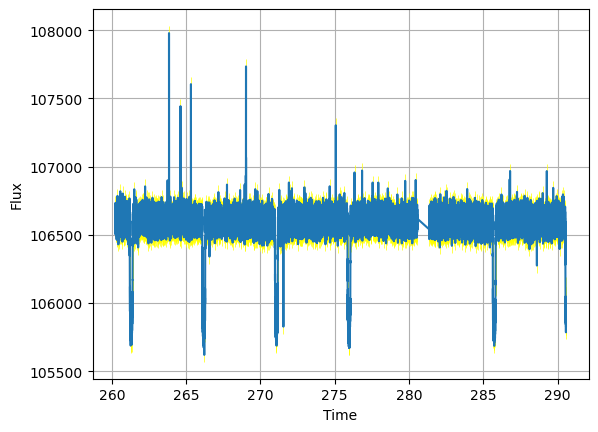

In [24]:
plt.figure
plt.errorbar(time, flux, yerr=flux_err, elinewidth=0.5, ecolor='yellow')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.grid(True)
plt.show()

In [47]:
# Problem 2 a
# The above shows an eclipse between t=280, and t=282. I am extracting these values using a mask.
mask = (time>=275.8) & (time<=276.1)
eclipse_time = time[mask]
eclipse_flux = flux[mask]
eclipse_flux_err = flux_err[mask]

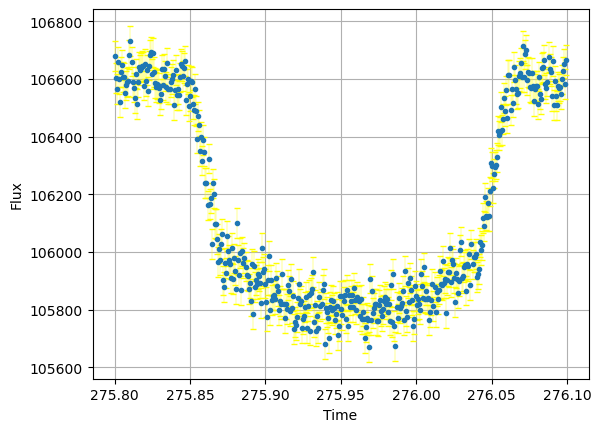

In [49]:
# Plotting the portion of eclipse
plt.figure
plt.errorbar(eclipse_time, eclipse_flux, yerr=eclipse_flux_err, fmt= '.', elinewidth=0.3, ecolor='yellow', capsize=2)
plt.xlabel('Time')
plt.ylabel('Flux')
plt.grid(True)
plt.show()

In [14]:
# Flux code from PS2 (corrected)
# Gives flux based on p and z
def lambda_function(p, z):
    if 1 + p < z:
        y = 0
    elif math.fabs(1-p) < z and z <= 1 + p:
        k0 = math.acos((p**2+z**2-1)/(2*p*z))
        k1 = math.acos((1-p**2+z**2)/(2*z))
        y = (p**2 * k0 + k1 - math.sqrt((4*z**2 - (1+z**2-p**2)**2)/4))/math.pi
    elif z <= 1-p:
        y = p**2
    elif z <= p-1:
        y = 1

    return y

def flux_function(p, z):
    return 1 - lambda_function(p, math.fabs(z))



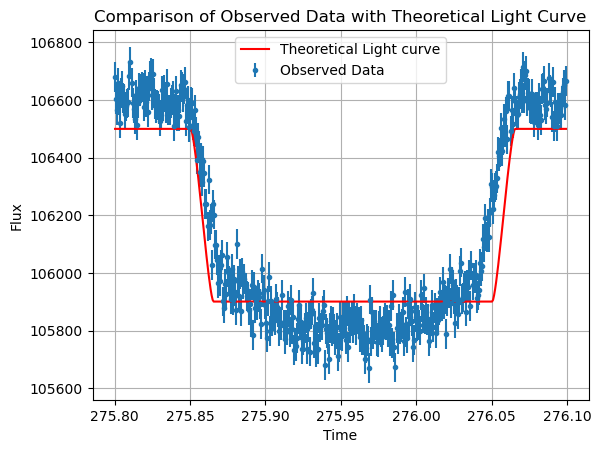

In [59]:
# Plotting comparison of observed data and theoretical light curve
p = 0.075
# t0 is the time of maximal eclipse which is extimated at the midpoint
t0 = 275.958 
# tau is the duration of the eclipse which is about 2 days
tau = 0.1
z_eclipse = (eclipse_time-t0)/tau
unobscured_flux = 106500
F_theoretical = [unobscured_flux*flux_function(p, z) for z in z_eclipse]
plt.figure
plt.errorbar(eclipse_time, eclipse_flux, yerr=flux_err[mask], label='Observed Data', fmt='.')
plt.plot(eclipse_time, F_theoretical, label='Theoretical Light curve', color='red')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Comparison of Observed Data with Theoretical Light Curve')
plt.legend()
plt.grid(True)
plt.show()

In [75]:
# Problem 2 part b
# Using flux code from PS2 which includes limb darkening

# Simpsons integral approximation used in flux function that incorporates limb darkening
"""
This function takes the following imputs:
f: the integrand
x0: lower limit of integral
xn: upper limit of integral
n: number of different subintervals

delta_x: the width of each subinterval

This function uses parabolas to create an approximation of an integral
"""
def approximate_int_simpsons(f, x0, xn, n):
    delta_x = (xn - x0) / n
    simpsons_approx = 0

    for i in range(n):
        xi = x0 + i * delta_x
        xi1 = x0 + (i + 1) * delta_x
        simpsons_approx += (f(xi) +  4*f((xi + xi1) / 2) + f(xi1)) * delta_x / 6

    return simpsons_approx

def calc_i(r):
    u = math.sqrt((1-r**2))
    i = 1 - (1 - u**1.5)
    return i

# Delta function is within F(p, |z|)
def delta_function(p, r, z):
    if r >= z + p or r <= z -p:
        return 0
    elif r + z <= p:
        return 1
    else:
        return math.pi**(-1)*math.acos((z**2 - p**2 + r**2)/(2*r*z))

# Function has an integral in both the numerator and denominator, so they will be computed indidual
def integrand_numerator(r):
    return calc_i(r)*(1 - delta_function(p, r, z))*2*r

#Computation of the integral in the denominator
def integrand_denominator(r):
    return calc_i(r)*2*r

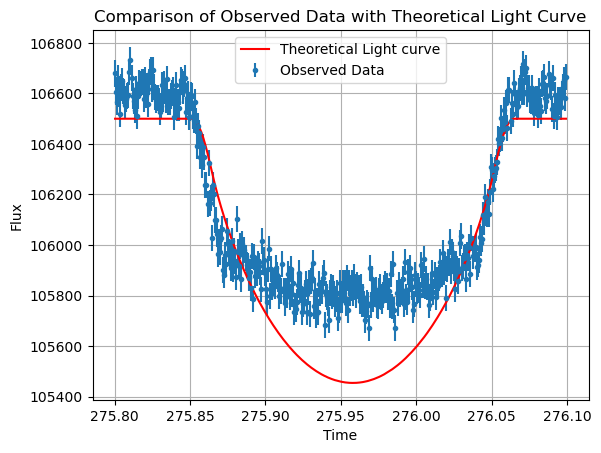

In [72]:
# Plotting flux vs time for theoretical light curve accounting for limb darkening
p = 0.075

# t0 is the time of maximal eclipse which is extimated at the midpoint
t0 = 275.958

# tau is the duration of the eclipse which is about 2 days
tau = 0.1

# we set n to 1000 as it doesnt make much difference to use 10,000 or 100
n = 1000

unobscured_flux = 106500

#starting global z, changes overtime
z = 0.4

# calculate theoretical flux for different z's
f_theoretical_limb_darkening = []
z_eclipse = (eclipse_time-t0)/tau
for _z in z_eclipse:
    # set the instance of z to the global z to be used in the functions
    z = abs(_z)
    f_pz = approximate_int_simpsons(integrand_numerator, 0, 1, n)/approximate_int_simpsons(integrand_denominator, 0, 1, n)
    f_theoretical_limb_darkening.append(unobscured_flux*f_pz)

# plot the theoretical vs observed data
plt.figure
plt.errorbar(eclipse_time, eclipse_flux, yerr=flux_err[mask], label='Observed Data', fmt='.')
plt.plot(eclipse_time, f_theoretical_limb_darkening, label='Theoretical Light curve', color='red')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Comparison of Observed Data with Theoretical Light Curve')
plt.legend()
plt.grid(True)
plt.show()


In [74]:
# Problem 3 

# Determining the value of Teff for a radius of d = 0.5 AU using the secant method

# Given values
a = 8.177e-5
b = 1.706e-9
Seff_sun = 1.014

# Using given equations
# calc_f finds the habitable zone distance given the luminosity and effective solar constant, and returns how far the distance is from 0.5 AU
def calc_f(Teff):
    T_star = Teff - 5780
    Seff = Seff_sun + a * T_star + b * T_star**2
    L_over_L_sun_value = (Teff / 5780)**4
    d_value = L_over_L_sun_value * Seff**(-1/2)
    return d_value - 0.5

# Secant method
"""
Secant method is a root finding method. Here it finds an effective temperature that gives a calc_f value close to 0.
Function takes in the following parameters:
Teff0: Initial guess of effective temperature
Teff1: Initial guess of effective temperature
tol: allowable error between successive approximations
max_iter: maximum iterations allowed to take place
"""
def secant_method(Teff0, Teff1, tol=1e-6, max_iter=1000):
    for _ in range(max_iter):
        f0 = calc_f(Teff0)
        f1 = calc_f(Teff1)

        # Calculate the next approximation
        Teff2 = Teff1 - f1 * (Teff1 - Teff0) / (f1 - f0)

        if abs(Teff2 - Teff1) < tol:
            return Teff2

        # Update values for next iteration
        Teff0, Teff1 = Teff1, Teff2

# Initial guesses for Teff; effective temperature of the Sun and value close to it  
Teff0 = 5780
Teff1 = 5790

Teff_solution = secant_method(Teff0, Teff1)
print(Teff_solution)

4821.1103194986645
